# Vision Transformer (ViT) Implementation Using Pytorch

This notebook demonstrates the implementation of a Vision Transformer (ViT) from scratch using PyTorch. The Vision Transformer is a model for image classification that leverages the Transformer architecture, which has been highly successful in natural language processing tasks.

We will be using the CIFAR-10 dataset for training and evaluating our model. The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 different classes, with 6,000 images per class. The dataset is divided into 50,000 training images and 10,000 test images.

The implementation includes the following components:
- **Patcher**: Divides the input image into smaller patches.
- **LinearProjectionFlatten**: Projects the patches into a higher-dimensional space.
- **PositionalEncoder**: Adds positional information to the patches.
- **SelfAttention**: Implements the self-attention mechanism.
- **AttentionBlock**: Combines self-attention with linear projections.
- **TransformerEncoder**: Stacks multiple attention blocks with normalization and feed-forward layers.
- **MLPHead**: A simple feed-forward network for final classification.
- **VisionTransformer**: Combines all components to form the complete Vision Transformer model.

The model is trained on the CIFAR-10 dataset for 10 epochs using the Adam optimizer and cross-entropy loss. The training loss is plotted to visualize the training process, and the model's prediction for a sample image is compared with the true label.

### Import libraries

In [1]:
from tqdm import tqdm

import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, CIFAR10
from torchvision.transforms import transforms
from einops import rearrange

## Prepare the Data (Cifar10)

In [3]:
# A simple transform for data since real focus is on ViT
transform = transforms.Compose([
    transforms.ToTensor()
])

# One-hot encoding the target labels
def one_hot_encode(label):
    return F.one_hot(torch.tensor(label), num_classes=10).float()

train_dataset = CIFAR10(
    root='../../../datasets',
    train=True,
    download=True, # Download the dataset if it does not exist
    transform=transform,
    target_transform=one_hot_encode
)

test_dataset = CIFAR10(
    root='../../../datasets',
    train=False,
    download=True, # Download the dataset if it does not exist
    transform=transform,
    target_transform=one_hot_encode
)

100%|██████████| 170M/170M [04:03<00:00, 700kB/s]  


In [4]:
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=True)

In this notebook, we will implement the Vision Transformer (ViT) architecture as described in its original paper.

![Vision Transformer](ViT_image_paper.png)


# Vision Transformer (ViT)

The Vision Transformer (ViT) is an adaptation of the Transformer architecture, originally developed for NLP, to the vision domain. It treats images as sequences of patches and applies a standard Transformer encoder for image classification.

---

## 1. Input Representation

Unlike CNNs, ViT does not operate on pixels directly but divides the image into fixed-size patches.

### Steps:

1. **Split the image** into non-overlapping patches of size $(P \times P)$.
2. **Flatten** each patch into a vector.
3. **Linearly project** each patch to a lower-dimensional embedding space.
4. **Add positional embeddings** to each patch embedding.
5. **Prepend** a learnable `[CLS]` token embedding.

### Example:

For an image of size $H \times W \times C$:

- Patch size = $P \times P$
- Number of patches = $N = \frac{HW}{P^2}$

Then each patch is flattened and mapped via a linear layer:

$$
x_i = \text{Flatten}(p_i) \in \mathbb{R}^{P^2 \cdot C} \\
z_i = x_i W_E + b_E \in \mathbb{R}^D
$$

Where:
- $W_E$ is the patch embedding matrix of size $(P^2 \cdot C) \times D$,
- $z_i$ is the projected patch embedding,
- $D$ is the Transformer hidden dimension.

The input sequence becomes:

$$
Z_0 = [x_{\text{cls}}; z_1; z_2; \dots; z_N] + PE
$$

Where:
- $x_{\text{cls}}$ is the learnable classification token,
- $PE$ is the positional embedding matrix.

---

## 2. Transformer Encoder

ViT uses the **standard Transformer encoder** from NLP, composed of multiple layers of:

1. **Multi-head self-attention (MHSA)**:
   Each patch attends to all others (including `[CLS]`).

2. **Feed-forward network (FFN)**:
   Applies a 2-layer MLP to each token independently.

3. **Layer normalization** and **residual connections** are used around each sub-layer.

---

### Multi-head Self-Attention (MHSA)

Self-attention allows each token to gather information from every other token in the sequence.

Given input sequence $X \in \mathbb{R}^{(N+1) \times D}$, we compute:

1. **Linear projections** to query, key, and value:

$$
Q = XW^Q, \quad K = XW^K, \quad V = XW^V
$$

where:

- $W^Q, W^K, W^V \in \mathbb{R}^{D \times d_k}$ are learned matrices,
- $Q, K, V \in \mathbb{R}^{(N+1) \times d_k}$ for each head.

2. **Scaled dot-product attention**:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left( \frac{QK^T}{\sqrt{d_k}} \right) V
$$

This computes attention scores between all patches.

3. **Multi-head Attention**:

Instead of using a single attention head, we use $h$ heads, each with different projections:

$$
\text{MHSA}(X) = \text{Concat}(\text{head}_1, \dots, \text{head}_h) W^O
$$

Each head is:

$$
\text{head}_i = \text{Attention}(XW^Q_i, XW^K_i, XW^V_i)
$$

Where:

- $W^Q_i, W^K_i, W^V_i \in \mathbb{R}^{D \times d_k}$,
- $W^O \in \mathbb{R}^{hd_k \times D}$ is the output projection matrix.

**Total output** after MHSA is again of shape $\mathbb{R}^{(N+1) \times D}$.

---

### Feed-forward Network (FFN)

Each token (including `[CLS]`) goes through:

$$
\text{FFN}(x) = \max(0, xW_1 + b_1)W_2 + b_2
$$

Where:

- $W_1 \in \mathbb{R}^{D \times D_{ff}}, W_2 \in \mathbb{R}^{D_{ff} \times D}$
- Typically, $D_{ff} = 4D$

---

## 3. Classification Head

After passing through the Transformer layers, only the `[CLS]` token is used for prediction:

$$
\hat{y} = \text{softmax}(W_{\text{cls}} \cdot x_{\text{cls}} + b)
$$

---

## 4. Positional Embeddings

Since Transformers lack inductive biases like locality and translation equivariance, **positional encodings** are added to the patch embeddings.

These are typically **learned** vectors:

$$
Z_0 = [x_{\text{cls}}; z_1; \dots; z_N] + PE \in \mathbb{R}^{(N+1) \times D}
$$

---

## 5. Summary

| Component         | Purpose                                                       |
|-------------------|---------------------------------------------------------------|
| Patch embedding   | Converts image patches into a sequence of tokens              |
| Positional encoding | Adds positional information for patch order                  |
| Transformer encoder | Learns relationships among patches via attention             |
| `[CLS]` token     | Summary representation used for final classification          |
| MLP Head          | Predicts class probabilities from `[CLS]` token               |

---

## Advantages of ViT

- Scalable to very large datasets.
- More flexible and general than CNNs.
- Can model long-range dependencies better.

## Limitations

- Needs **a lot of data** to outperform CNNs.
- Lacks some inductive biases (e.g., translation equivariance, locality).

---

## References

- [ViT Paper - "An Image is Worth 16x16 Words"](https://arxiv.org/abs/2010.11929)

# Patcher

The `Patcher` class is responsible for dividing the input image into smaller patches. Each patch is then flattened into a vector.

In [90]:
class Patcher(nn.Module):
    def __init__(self, height=28, width=28, patch_size=16, embed_dim=512):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = (height // patch_size) * (width // patch_size)
        self.embed_dim = embed_dim

    def forward(self, x: Tensor):
        # Batch size, Num patches, Flatten features
        patches = rearrange(x, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=self.patch_size, p2=self.patch_size)
        return patches

# LinearProjectionFlatten

The `LinearProjectionFlatten` class takes the patches created by the `Patcher` and projects them into a higher-dimensional space using a linear layer.

In [91]:
class LinearProjectionFlatten(nn.Module):
    def __init__(self, patcher: Patcher, num_channels=3):
        super().__init__()
        self.patcher: Patcher = patcher
        self.patch_embedding = nn.Linear(num_channels * patcher.patch_size ** 2, patcher.embed_dim)

    def forward(self, x: Tensor):
        patches = self.patcher(x)
        embedded_patches = self.patch_embedding(patches)
        return embedded_patches

# CLSAdder

The `CLSAdder` class is responsible for:

1. **Adding a `[CLS]` token** to the beginning of the sequence of patch embeddings.
2. **Adding positional embeddings** to retain spatial information.

In [92]:
class CLSAdder(nn.Module):
    def __init__(self, num_patches, embed_dim=512):
        super().__init__()

        self.cls_token = nn.Parameter(torch.randn((1, 1, embed_dim)))
        self.positional_token = nn.Parameter(torch.randn((1, num_patches + 1, embed_dim)))

    def forward(self, x: Tensor):
        batch_size, num_patches, embed_dim = x.size()

        cls_token = self.cls_token.expand(batch_size, -1, -1)

        x = torch.cat((cls_token, x), dim=1)
        x += self.positional_token
        return x

# SelfAttention

The `SelfAttention` class implements the self-attention mechanism, which allows the model to focus on different parts of the input sequence.

In [93]:
class SelfAttention(nn.Module):
    def __init__(self):
        super().__init__()

    def calculate_QKT(self, queries: Tensor, keys: Tensor):
        return torch.bmm(queries, keys.transpose(1, 2)) / np.sqrt(queries.shape[-1])
 
    def forward(self, queries: Tensor, keys: Tensor, values: Tensor, 
                batch_size: int, seq_len: int, embed_dim: int, n_head: int):
        
        keys = keys.transpose(1, 2).contiguous().view(batch_size * n_head, seq_len, embed_dim)
        queries = queries.transpose(1, 2).contiguous().view(batch_size * n_head, seq_len, embed_dim)
        values = values.transpose(1, 2).contiguous().view(batch_size * n_head, seq_len, embed_dim)

        QKT = self.calculate_QKT(queries, keys)
        scores = F.softmax(QKT, dim=2)
        attention: Tensor = torch.bmm(scores, values).view(batch_size, n_head, seq_len, embed_dim)
        attention = attention.transpose(1, 2).contiguous().view(batch_size, seq_len, embed_dim * n_head)
        return attention

# AttentionBlock

The `AttentionBlock` class combines the self-attention mechanism with linear projections to form a complete attention block.

In [94]:
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim=512, n_head=8):
        super().__init__()
        self.embed_dim = embed_dim
        self.n_head = n_head

        # W for queries
        self.Wq = nn.Linear(embed_dim, embed_dim * n_head, bias=False)
        # W for keys
        self.Wk = nn.Linear(embed_dim, embed_dim * n_head, bias=False)
        # W for values
        self.Wv = nn.Linear(embed_dim, embed_dim * n_head, bias=False)
        # W for final results
        self.Wr = nn.Linear(embed_dim * n_head, embed_dim)

        self.attention = SelfAttention()

    def forward(self, x: Tensor):
        n_head = self.n_head
        batch_size, seq_len, embed_dim = x.size()

        queries = self.Wq(x).view(batch_size, seq_len, n_head, embed_dim)
        keys = self.Wk(x).view(batch_size, seq_len, n_head, embed_dim)
        values = self.Wv(x).view(batch_size, seq_len, n_head, embed_dim)

        result = self.attention(queries, keys, values, batch_size,
                                seq_len, embed_dim, n_head)
        
        return self.Wr(result)

# TransformerEncoder

The `TransformerEncoder` class stacks multiple attention blocks and adds normalization and feed-forward layers.

In [95]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim=512, n_head=8):
        super().__init__()

        self.attention = AttentionBlock(embed_dim, n_head)

        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        hidden_size = embed_dim * 2
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, embed_dim)
        )

    def forward(self, x: Tensor):
        sc = self.attention(x) # First skip connection
        x = self.norm1(x + sc)
        sc = self.mlp(x)
        out = self.norm2(x + sc) # Second skip connection
        return out

# MLPHead

The `MLPHead` class is a simple feed-forward network that produces the final classification logits.

In [105]:
class MLPHead(nn.Module):
    def __init__(self, n_classes, embed_dim=512):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(embed_dim, n_classes)
        )

    def forward(self, x: Tensor):
        cls_token = x[:, 0, :]  # Only use [CLS] token
        logits = self.layers(cls_token)
        return logits

# VisionTransformer

The `VisionTransformer` class combines all the components to form the complete Vision Transformer model.

In [106]:
class VisionTransformer(nn.Module):
    def __init__(self, n_classes, height=28, width=28, patch_size=16, n_head=8, embed_dim=512, num_channels=3, n_transformers=6):
        super().__init__()

        patcher = Patcher(height, width, patch_size, embed_dim)
        self.linear_projection = LinearProjectionFlatten(patcher, num_channels)
        self.positional_embedding = CLSAdder(patcher.num_patches, embed_dim)

        transformer_encoders = [TransformerEncoder(embed_dim, n_head) for _ in range(n_transformers)]
        self.transformers = nn.Sequential(*transformer_encoders)

        self.mlp_head = MLPHead(n_classes, embed_dim)

    def forward(self, x: Tensor):
        flatten = self.linear_projection(x)
        
        positional_encoded = self.positional_embedding(flatten)

        transform = self.transformers(positional_encoded)
        return self.mlp_head(transform)

### Set device

In [107]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Training the Model

The model is trained on the CIFAR-10 dataset for 10 epochs using the Adam optimizer and cross-entropy loss.

In [108]:
model = VisionTransformer(n_classes=10, height=32, width=32, patch_size=4, n_head=4,
                        embed_dim=100, num_channels=3, n_transformers=3).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 20

train_losses = []
test_losses = []

for epoch in tqdm(range(epochs)):  
    num_batches = len(train_dataloader)

    epoch_loss_train = 0
    model.train()

    for img, label in train_dataloader:
        img: Tensor = img.to(device)
        label: Tensor = label.to(device)

        logits: Tensor = model(img)
        loss: Tensor = loss_fn(logits, label)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss_train += loss.item()

    # Using test dataset as validation dataset
    epoch_loss_test = 0

    model.eval()
    with torch.no_grad():
        for img, label in test_dataloader:
            img: Tensor = img.to(device)
            label: Tensor = label.to(device)

            logits: Tensor = model(img)
            loss: Tensor = loss_fn(logits, label)

            epoch_loss_test = loss.item()

    epoch_loss_train /= num_batches
    epoch_loss_test /= num_batches
    train_losses.append(epoch_loss_train)
    test_losses.append(epoch_loss_test)

    print(f"Epoch {epoch+1}, Train Loss: {epoch_loss_train:.4f}, Test Loss: {epoch_loss_test:.4f}")

  5%|▌         | 1/20 [00:20<06:23, 20.16s/it]

Epoch 1, Train Loss: 1.9096, Test Loss: 0.0074


 10%|█         | 2/20 [00:41<06:11, 20.66s/it]

Epoch 2, Train Loss: 1.6273, Test Loss: 0.0071


 15%|█▌        | 3/20 [01:02<05:59, 21.15s/it]

Epoch 3, Train Loss: 1.4967, Test Loss: 0.0090


 20%|██        | 4/20 [01:26<05:51, 21.97s/it]

Epoch 4, Train Loss: 1.4066, Test Loss: 0.0064


 25%|██▌       | 5/20 [01:49<05:35, 22.35s/it]

Epoch 5, Train Loss: 1.3349, Test Loss: 0.0062


 30%|███       | 6/20 [02:10<05:09, 22.13s/it]

Epoch 6, Train Loss: 1.2752, Test Loss: 0.0054


 35%|███▌      | 7/20 [02:33<04:48, 22.21s/it]

Epoch 7, Train Loss: 1.2222, Test Loss: 0.0057


 40%|████      | 8/20 [02:55<04:26, 22.24s/it]

Epoch 8, Train Loss: 1.1836, Test Loss: 0.0070


 45%|████▌     | 9/20 [03:20<04:12, 22.95s/it]

Epoch 9, Train Loss: 1.1307, Test Loss: 0.0062


 50%|█████     | 10/20 [03:44<03:53, 23.34s/it]

Epoch 10, Train Loss: 1.0936, Test Loss: 0.0068


 55%|█████▌    | 11/20 [04:06<03:26, 22.90s/it]

Epoch 11, Train Loss: 1.0583, Test Loss: 0.0061


 60%|██████    | 12/20 [04:28<03:00, 22.62s/it]

Epoch 12, Train Loss: 1.0269, Test Loss: 0.0066


 65%|██████▌   | 13/20 [04:51<02:38, 22.70s/it]

Epoch 13, Train Loss: 0.9811, Test Loss: 0.0044


 70%|███████   | 14/20 [05:14<02:18, 23.07s/it]

Epoch 14, Train Loss: 0.9470, Test Loss: 0.0083


 75%|███████▌  | 15/20 [05:38<01:56, 23.30s/it]

Epoch 15, Train Loss: 0.9200, Test Loss: 0.0084


 80%|████████  | 16/20 [06:02<01:34, 23.52s/it]

Epoch 16, Train Loss: 0.8841, Test Loss: 0.0054


 85%|████████▌ | 17/20 [06:26<01:10, 23.43s/it]

Epoch 17, Train Loss: 0.8518, Test Loss: 0.0088


 90%|█████████ | 18/20 [06:49<00:46, 23.50s/it]

Epoch 18, Train Loss: 0.8186, Test Loss: 0.0045


 95%|█████████▌| 19/20 [07:13<00:23, 23.49s/it]

Epoch 19, Train Loss: 0.7818, Test Loss: 0.0074


100%|██████████| 20/20 [07:36<00:00, 22.80s/it]

Epoch 20, Train Loss: 0.7617, Test Loss: 0.0071


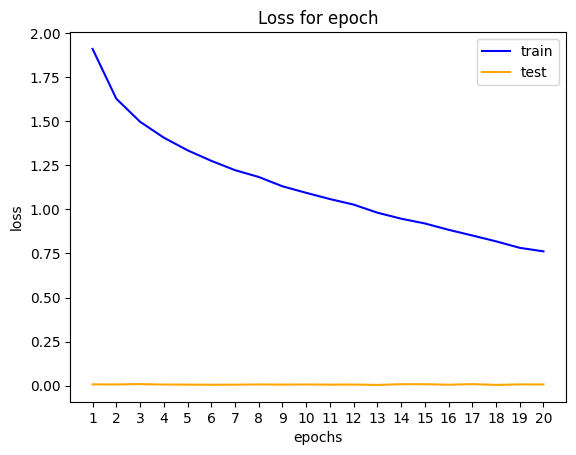

In [109]:
plt.plot(range(1, len(range(epochs)) + 1), train_losses, label='train', color='blue')
plt.plot(range(1, len(range(epochs)) + 1), test_losses, label='test', color='orange')
plt.legend()
plt.title('Loss for epoch')
plt.xticks(range(1, epochs + 1))
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()